In [1]:
import numpy as np
import scipy.stats
import scipy.fftpack
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import lds_utils, seq_utils

# Introduction

The goal of this exercise is part tutorial in discrete linear dynamical systems, part exploration of low frequency oscillatory dynamics, a feature that is increasingly found in datasets recorded from motor cortical regions of the brain. The tutorial part covers basics of discrete linear dynamical systems (part I) and a review of how the parameters fit by a dynamcis model can be analyzed and visualized to better understand what spatiotemporal patterns the model has captured (part II). The next part then covers how to use discrete linear dynamical systems in practice to analyze data (part III). Finally, part IV investigates what sorts of spatiotemporal patterns of data give rise to low-freuqency oscillatory dynamics that have been increasingly reported in motor cortical electrophysiology data (part IV). 

# Part I: Behavior of Discrete Linear Dynamical Systems
In this part, we review analysis of discrete, linear dynamical systems and illustrate in 2D typical behaviors 

Consider the system:  

$x_t = A x_{t-1}$ 

where $x_t$ is a 2x1 vector. In words, $A$ represents a linear transform, predicting $x_t$ based only on the activity of $x_{t-1}$. Similarly, one can write $x_{t-1} = A x_{t-2}$ and see that $x_{t-1}$ too is just a prediction forward from $x_{t-2}$ through the same linear transform $A$. By continuing to work backwards to solve for $x_t$, we arrive at the solution: 

$x_t = A x_{t-1} = A (A x_{t-2}) = A(A(A x_{t-3})) = ... = A^t x_0$. 

Thus, $x_t$ is just the result of an initial condition $x_0$ propagated forward in time $t$ times by linear transform $A$. Note that sometimes a slightly different form of this expression used, but it expresses the same idea: 


$dx = x_{t} - x_{t-1} = Ax_{t-1}$

In fact we can re-write this equation in a similar form to the one we started with above: 

 $x_{t} - x_{t-1} = Ax_{t-1}$

$x_t = Ax_{t-1} + x_{t-1}$

$x_t = (A+I)x_{t-1}$



$x_t = (A')x_{t-1}$ where $A' = A+I$. So, what sort of trajectories through time can $A$ or $A'$ generate? Consider the following examples:

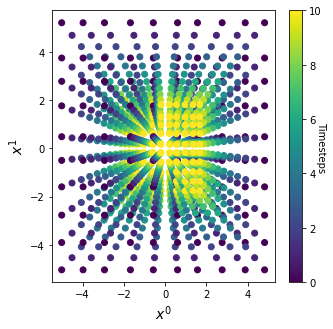

In [5]:
### Example 1
### Define 2x2 A matrix: 
A1 = np.mat([[.9, 0.], [0., 0.9]])

### Method to randomly initialize (nEx**2) 2D points, and propagate each point by A (nT) times
### This method takes each x0 point, plots it, then multiplies it by A, 
### plots that resultant point, then multiplies that resultant point by A, then plots it ... etc.

### Try adjusting the number of timepoints or density of initial conditions by adjusting nEx or nT: 
lds_utils.plot_example_x0(A1, nEx = 10, nT = 10)

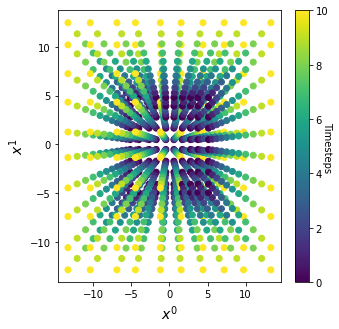

In [6]:
### Example 2
### Define A matrix: 
A2 = np.mat([[1.1, 0.], [0., 1.1]])
lds_utils.plot_example_x0(A2, nEx = 10, nT = 10)

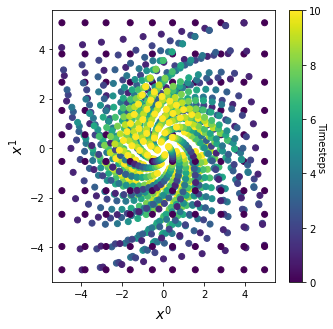

In [7]:
### Example 3
### Define A matrix: 
A3 = np.mat([[.9, -.1], [.1, 0.9]])
lds_utils.plot_example_x0(A3, nEx = 10, nT = 10)

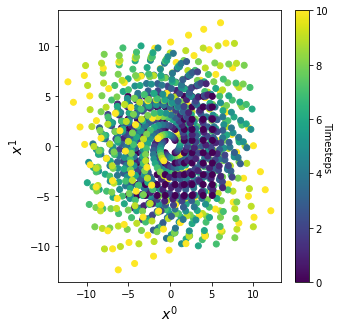

In [8]:
### Example 4
### Define A matrix: 
A4 = np.mat([[1.05, -.2], [.2, 1.05]])
lds_utils.plot_example_x0(A4, nEx = 10, nT = 10)

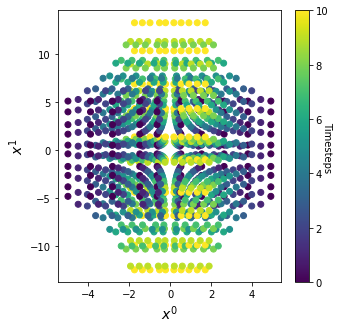

In [9]:
### Example 5
### Define A matrix: 
A5 = np.mat([[.9, 0.], [0., -1.1]])
lds_utils.plot_example_x0(A5, nEx = 10, nT = 10)

In the four examples, the dark bluepurple points are the $x_0$ conditions, and the green and yellow points are the $x_0$ conditions that have been propagated in time by $A$. These five examples exemplify 1) a sink, 2) an explosion 3) an inward spiral, 4) an outward spiral, and 5) a saddle. Broadly, these characterize the most common types of behavior that are observed given an $A$ matrix. We split these examples in two categories; a) **stable vs. unstable**, and b) **oscillatory vs. non-oscillatory**. In the above examples, example 1 and 3 exhibit stable behavior (not exploding), and examples 2 and 4 exhibit unstable behavior (exploding). Example 5 has one unstable and one stable direction. Examples 1,  2, and 5 exhibit non-oscillatory behavior, while examples 3 and 4 exhibit oscillatory behavior. 

While these plots are easy to make in 2D, sometimes we want to analyze the behavior of higher dimensional datasets which are hard to make and look at, and second may be composed of many different types of behaviors (i.e mixes of the above examples). How can we figure out what the dominant behavior types of an NxN A matrix are without having to make tons of subplots and trying to imagine high dimensional space?  

# Part II: Analyzing $A$ to infer dynamical behavior

Turns out that we can decompose the A matrix in a way that gives insight into the computations it performs. I won't review the concept of eigenvalues and eigenvectors here, but it is necessary to understand the next steps. Here is a great refresher: https://www.youtube.com/watch?v=PFDu9oVAE-g

So let's return to the solution of the dynamics equation for $x_t$: 
$x_t = A^t x_0$. Unless $A$ is the identity matrix or a zero matrix, presently its unclear what dynamics we should expect $A^t$ to exhibit compared to $A$. In order to make this more clear, we'll decompose $A$. 

Let's assume that $A$ is a simple matrix $\in \mathbb{R}^{nxn}$, and so we can decompose it into $n$ distinct and linearly independent eigenvectors ($v_i \in \mathbb{C}^n, i = 1...n$) and respective non-zero eigenvalues ($\lambda_i \in \mathbb{C}^1, i = 1...n$). For each eigenvector and eigenvalue, we can write: 

$ A v_i = \lambda_i v_i$ for all $i = 1...n$

Here, $v_i$ is an $ n x 1 $ vector. We can write $v_i$ as a column and horizontally stack up all the $v_i s$ to a large matrix we'll call $T$. Then we can also place the $\lambda_i$s on the diagonal of a matrix $\Lambda$.  This is written as: 

$ A \begin{bmatrix} v_1 & v_2 & ... & v_n \end{bmatrix} = \begin{bmatrix} v_1 & v_2 & ... & v_n \end{bmatrix}\begin{bmatrix} \lambda_1 & 0 & ... & 0 \\ 0 & \lambda_2 & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n \end{bmatrix}$

Or more simple as: 

$A T = T \Lambda $

Since we assumed that $A$ was decomposible into $n$ linearly independent eigenvectors with non-zero eigenvalues, that's all we need to know to confirm that $T$ is an invertible matrix. We can then write: 

$ A = T \Lambda T^{-1}$

Why is this useful? If we return to the solution $x_t = A^t x_0$, its hard to imagine what $A^t$ would look like without actually multiplying out $A$ all $t$ times. However, if replacing $A$ with $ T \Lambda T^{-1}$, makes the solution start to look more understandable: 

$x_t = A^t x_0$

$x_t = ( T \Lambda T^{-1})^t x_0 $

$x_t = ( T \Lambda T^{-1}) ( T \Lambda T^{-1}) ... ( T \Lambda T^{-1}) x_0$

$x_t =  T \Lambda T^{-1}  T \Lambda T^{-1}  ...  T \Lambda T^{-1}  x_0$

Now, if we look closely, we see that there a number of $T^{-1}T $s that would evaluate to the identity matrix. If we remove all the $T^{-1}T$s, we're left with:

$x_t = T \Lambda \Lambda ... \Lambda T^{-1}  x_0$

$x_t = T\Lambda^t T^{-1} x_0$

Now consider multiplying both sides by $T^{-1} $ and defining a new variable $z = T^{-1} x$. Now, instead of studying the effects of $A$ operating on $x$, we can now think of $\Lambda$ operating on $z$. This particular linear transformation will make it easier for us to "see" what sorts of dynamical behavior $A$ generates. 

$T^{-1} x_t = T^{-1} T \Lambda^t T^{-1}  x_0$

$T^{-1} x_t = \Lambda^t T^{-1}  x_0$

$z_t = \Lambda^t z_0$ after substituting $z = T^{-1} x$

$z_t = \begin{bmatrix} \lambda_1 & 0 & ... & 0 \\ 0 & \lambda_2 & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n \end{bmatrix} ^t z_0$

$z_t = \begin{bmatrix} \lambda_1^t & 0 & ... & 0 \\ 0 & \lambda_2^t & ... & 0 \\ \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & \ldots & \lambda_n^t \end{bmatrix} z_0$

Now, this is something we can analyze easily! With an eigenvalue decomposition of A followed by a change of variable, we've ended up with a new dynamics matrix $\Lambda$ operating on variable $z$ such that each dimension of $z$ is only ever influenced by itself. In other words, all the dimensions aren't mixed together as they may have been if we looked at the A matrix operating on $x$. If we consider just a single dimension, $z^i$, we can now write: 

$z_t^i = \lambda_i^t z^i_0$

A final manipulation allows us to analyze the effects of $\lambda_i^t$. Since $\lambda_i \in \mathbb{C}, \lambda_i = a_i + b_i i$, we can re-write $\lambda_i = r_i e^{\theta_i i}$ where $r_i = \sqrt{(a_i^2 + b_i^2 )}$ and $\theta_i = tan^{-1} (\frac{b}{a})$

$z_t^i = (r_i e^{\theta_i i})^t z_0$ 

$z_t^i = (r_i^t e^{\theta_i i t}) z_0$

$z_t^i = (r_i^t [ cos(\theta_i t) + i sin(\theta_i t) ] ) z_0$

This expression indicates that $z_t^i$ will exponentially grow or decay over time (dictated by the $r_i$ value), and will oscillate at a frequence dictated by the $\theta_i$ value. Thus the behavior of the $z_i$ dimension is fully defined by the magnitude ($r_i$) and angle ($\theta_i$) of the eigenvalue ($\lambda_i$). With each step of $t, r_i^t$ will decay if $ r_i < 1$, or will explode if $ r_i > 1$. Thus, we call $\lambda_i$ **stable** for $r_i \leq 1$, and $\lambda_i$ **unstable** for $r_i > 1$. For stable $r_i$, the **decay time** associated with $\lambda_i$ is typically computed as the amount of time needed for $r_i^t$ to decay from $1$ at $t = 0$ to $\frac{1}{e}$:

$\frac{1}{e} = r_i^t$

$ln(\frac{1}{e}) = ln(r_i^t)$

$ln(e^{-1}) = t ln(r_i)$

$-ln(e) = t ln(r_i)$

$-1 = t ln(r_i)$

**Decay Time** $ = -\frac{1}{ln(r_i)}$ timesteps

Next, we can determine if $\lambda_i$ is **non-oscillatory** if $\theta_i = 0$, or that $\lambda_i$ is **oscillatory** if $\theta_i \neq 0$. Further, if $\lambda_i$ is oscillatory, $\theta_i$ corresponds to radians / timestep completed. This can be converted to **frequency** in Hz by dividing by $2\pi$ and then dividing by the length of each timestep in units of seconds. 

In conclusion, we can determine the behavior of a dynamics matrix $A$ by just looking at a plot of all eigenvalues plotted on axes of **time decay** vs. **oscillation frequency**. Let's try out these plots for the above A matrices: 

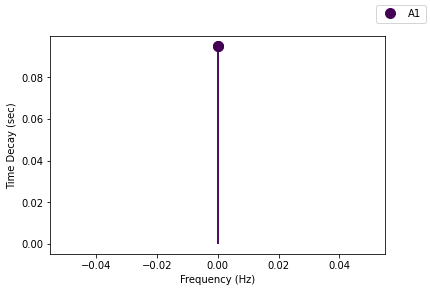

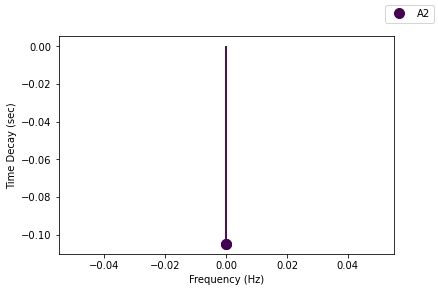

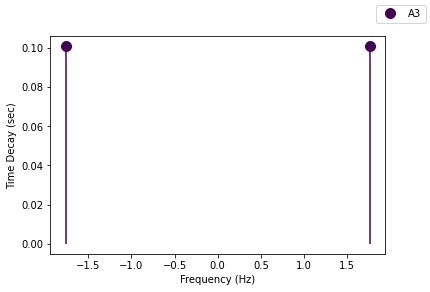

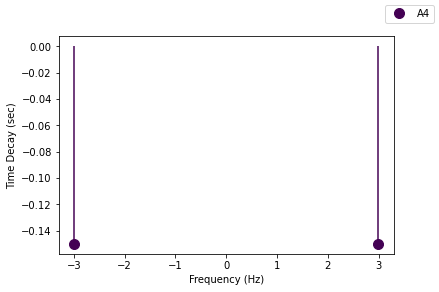

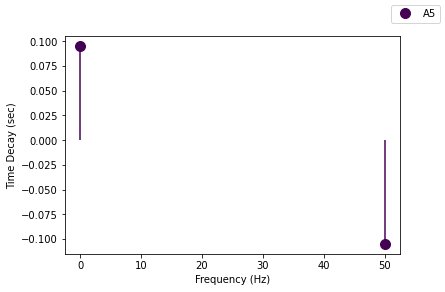

In [11]:
### Recall that A1 was a sink, A2 was an explosion, A3 was a sinking spiral, and A4 was an exploding spiral; 
for ia, A in enumerate([A1, A2, A3, A4, A5]):
  lds_utils.eigenspec(A, labels=['A%d'%(ia+1)])

A few things to note about the above plots: a) when there are unstable eigenvalues (i.e examples 2, 4, and part of 5), the time-decay values are negative and aren't interpretable, and b) when there is an oscillatory eigenvalue (i.e. examples 3, 4) both eigenvalues have the same time decay but opposite signs for oscillation frequency. This is expected -- oscillatory behavior requires two dimensions, and so eigenvalues corresponding to oscillatory modes come as a pair of complex conjugates ($a+bi, a-bi$) yielding $\theta$ and $-\theta$. 

See how 2D geometric rotation matrices of different frequencies can be analyzed through their eigenvalues: 

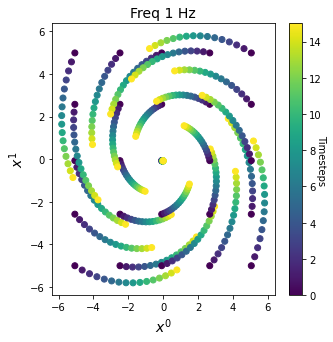

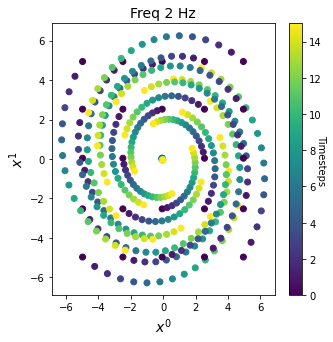

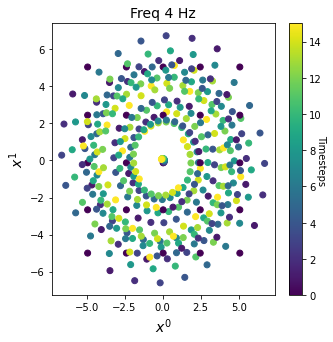

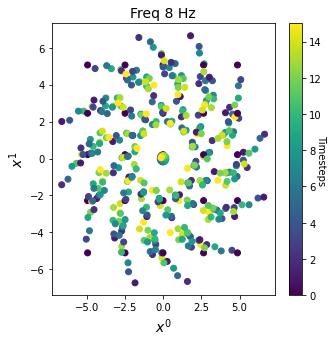

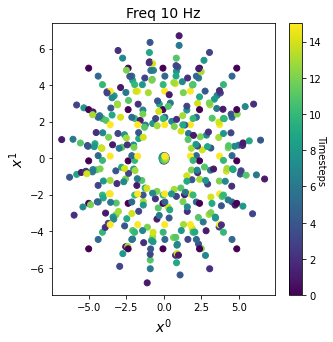

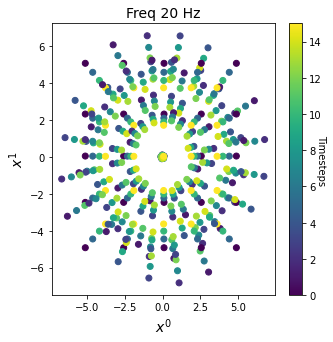

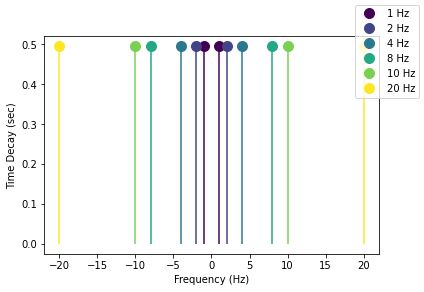

In [12]:
#### Example 6 -- Rotation matrices 
### Typically a 2D rotation matrix is defined as [cos(theta), -sin(theta)], [sin(theta), cos(theta)]
### Let's generate data from rotation matrices and see if analyzing the rotation 
### matrix yields eigenvalues that match the expected frequency

dt = 0.01 # each timestep is 10 ms; 
r_lamb = 0.98 # set the r value of the eigenvalues; 
A_set = []; ## holder for set of A matrices 
lab_set = []; ## holder for labels of A matrices 

for hz in [1, 2, 4, 8, 10, 20]:
    ### degrees per timestep
    rad = hz*dt*2*np.pi; #cycles/sec --> cycles / ts --> rad / ts 

    ### Generate rotation matrix with slight decay ###
    A = r_lamb*np.mat([[np.cos(rad), -1*np.sin(rad)],[np.sin(rad), np.cos(rad)]])

    ### Plot rotations ###
    lds_utils.plot_example_x0(A, nEx = 5, nT = 15, title='Freq %d Hz' %hz)

    ### Add to A_set for analysis ###
    A_set.append(A)
    lab_set.append('%d Hz'%hz)

### Plot the eigenspectrum of all these A matrices; 
lds_utils.eigenspec(*A_set, dt=dt, labels=lab_set)



     

# Part III: Fitting $A$ to observed datasets, and visualizing top dynamical dimensions of $A$

In the above examples, we generated data according to a given $A$ matrix and initial condition $x_0$. All data we created was perfectly adherent to $A$, without any external influences. Now, we're going to consider the opposite case where instead of having $A$ and using it to generate data, we have lots of data, and we try to estimate $A$ and then analyze $A$ to tell us something about the dynamics of our data. 

We will generate some fake data, then fit an $A$ matrix to the data, quantify how well this $A$ matrix fits the data, and then plot the eigenspectrum. Note that going forward we will only concern ourselves with **stable** systems. 

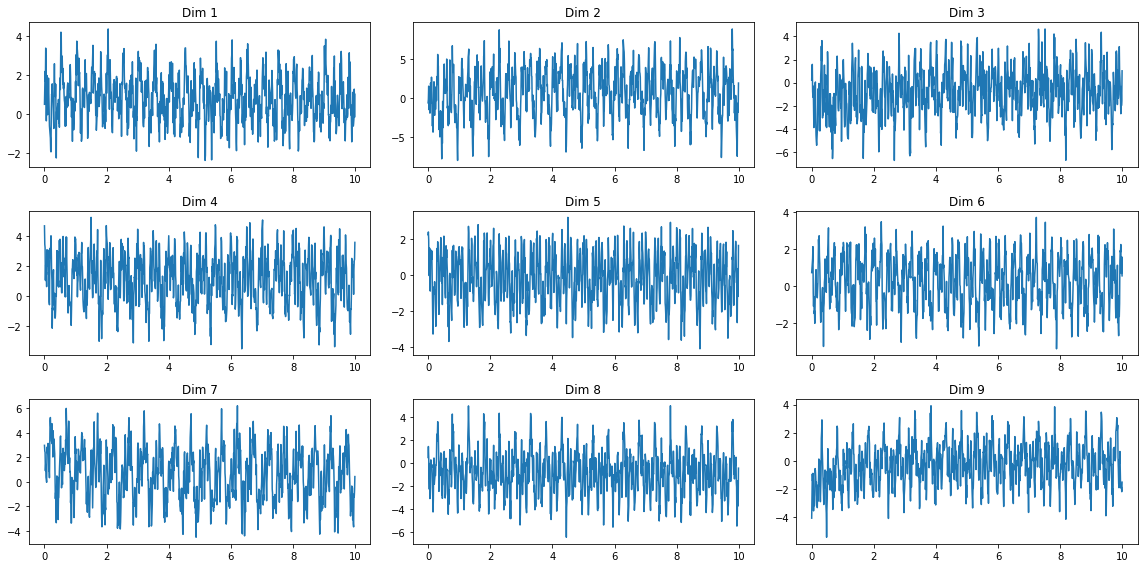

In [13]:
## Generate fake data; 
nT = 1000; ## Number of data points 
dt = 0.01 ## Seconds per timestep; 

### Time axis: 
T = np.arange(0., dt*nT, dt)
added_noise = 0.3 ##std of gaussian distribution; 

## For generating a few sine waves:
f1 = 2; f2 = 4; f3 = 10; # Hz 

## For generating a few exponential decays: 
r1 = .2; r2 = .5; r3 = .99

## Storage for components used to create data: 
X = []; 

## Generate a few sine waves:
for f in[f1, f2, f3]:
    s1 = np.sin(2*np.pi*f*T)
    c1 = np.cos(2*np.pi*f*T)

    ## Add them to X
    X.append(s1)
    X.append(c1)

## Generate a few exponential decays: 
for r in [r1, r2, r3]:
    exp_dec = r**T
    X.append(exp_dec)

### Now X is full of oscillating and decaying waveforms ###
X = np.vstack((X)).T
assert(X.shape[0] == nT)

_, nD = X.shape

### Let's add a bit of noise
X += added_noise*np.random.randn(nT, nD) 

### Now lets randomly mix these waveforms together ##
Mixing = np.random.randn(nD, nD)
Data_mixed = np.dot(Mixing, X.T).T

### Plot our fake data 
f, ax = plt.subplots(ncols = 3, nrows = int(np.ceil(nD/3)), figsize=(16, 8))
for i in range(nD):
  axi = ax[int(i/3), i%3]
  axi.plot(T, Data_mixed[:, i])
  axi.set_title('Dim %d' %(i+1))
f.tight_layout()


Now say we want to estimate an A matrix for this data. We can do a simple least squares linear regression where each data point $x_t$ is fit as a linear funciton of $x_{t-1}$: 

In [0]:
## Setup X_t, X_{t-1}; 
Xt = Data_mixed[1:, :] ## All data points except first
Xtm1 = Data_mixed[:-1, :] ## All data points except last 

## Fit an A matrix using least squares linear regressions: 
Aest = np.linalg.lstsq(Xtm1, Xt, rcond=None)[0] 

### This function solves for A: x_t = x_t-1 A, so we take the transpose
Aest = Aest.T

Note, that if the dimesionality of X is high (i.e. $nD$ is high), it can be challenging to fit A, since need to estimate $nD^2$ entries. Methods for improving robust fits of A include ridge regression, dynamic mode decomposition (Tu, 2012), using least squares for sparse matrices, and probably others. 

First, lets get a sense of how well Aest captures the fluctuations of the data above. We already know its probably not going to be perfect, since we added some noise. We'll use the $R^2$ or variance accounted for metric: 

In [15]:
print("R2 of Aest = %.3f"%(lds_utils.get_population_R2(Xt, np.dot(Aest, Xtm1.T).T)))

R2 of Aest = 0.692


Now knowing that the $A$ matrix captures ~70% of neural variance, we can then proceed to analyze what structure it has: 

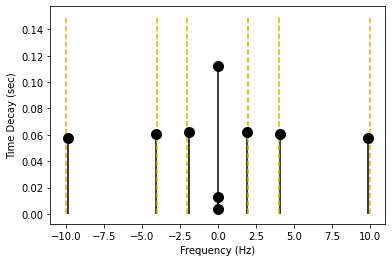

In [20]:
### Now let's take a look at the eigenvalues: 
ev, _ = np.linalg.eig(Aest)

### And get the time decay and frequency: 
td = -1/np.log(np.abs(ev))*dt 
hz = np.angle(ev)/(2*np.pi*dt)

f, ax = plt.subplots()
ax.plot(hz, td, 'k.', markersize=20)
ax.vlines(hz, 0, td, 'k')
ax.set_ylabel('Time Decay (sec)')
ax.set_xlabel('Frequency (Hz)')

### Mark where the frequencies we set are
ax.vlines([f1, f2, f3, -f1, -f2, -f3], 0, .15, 'y', linestyle='dashed')

We can see above that the main frequencies $f_1, f_2, f_3$ that we put into the fake data (marked by the dashed yellow lines) are being captured by A; There are also a few non-oscillatory components (centered at zero) that predict exponential decay with time constants of ~120ms, 15ms, and ~0 ms. Its worth remembering that in this dataset, the timestep $dt$ is 0.01 sec, or 10 ms. Thus, any decays calculated to be less than 10ms are not making substantial predictions since they exhibit time decays faster than the passage of a single bin. 

Now let's say we wanted to visualize the dimensions with dynamical properties that are most present in the data. If we just wanted the most total variance, we'd do PCA on the data and visualize the top dimensions. If we want to see the dimensions that capture the most persistent (longest time decay) dynamical features, that means we want to see the dimensions with the largest eigenvalues. 

A key idea is that the eigenvalues with the longest time decays are the ones with properties that are most present in the data. The dynamics associated with eigenvalues with very short time decays are not strongly present in the data. 

Thus to capture and visualize the top dynamical dimensions, we want to do the change of basis from $x_1, x_2, ... x_n$ to $z_1, z_2, ... z_n$ as we defined above ($z = T^{-1} x$), and then visualize the top $z$ dimensions. For a review on how this works for complex eigenvalues / vectors see: https://www.youtube.com/watch?v=qlUr2Jc5O0g

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


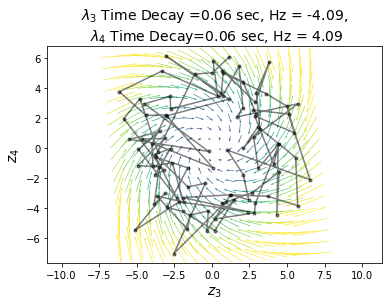

In [24]:
### Play around which which dimensions to visualize ###
### Notice that some pairs will look like oscillations, some will show only decays ###
### Remember that python uses 'zero-indexing' 

dim0 = 3; 
dim1 = 4; 
color_max = 2.### Can adjust the colorbar limits ([0, color_max]) for the arrows. 

### Here the "flow field" predicted by Lambda is illustrated -- for each point on the plane
### spanned by dim0 x dim1, the lambda matrix is used to predict the next time step (Lambda z_{t-1})
### resulting in an arrow from z_{t-1} to Lambda z{t-1}. Arrows are colored by their magnitude. 

### The title of the plot will tell you the time decay and frequency of oscillation of each of the eigenvalues
### associated with the dimensions you are plotting. Notice that their properties 
### match the graph above 

### the black lines with dots plot the first 100 datapoints (1 second) of the fake generated data (i.e. Ztm1)
### so notice which dimensions seem to capture the changes in the data best; 

lds_utils.flow_field_plot_top_dim(Aest, Xtm1, dt, dim0=dim0, dim1=dim1, cmax=color_max)

# Part IV: Spatiotemporal Patterns With Rotational Dynamics

Now that we have the tools to analyze a linear dynamics matrix $A$ and to visualize the dominant modes of the dynamics capture by $A$, we now turn to studying how low frequency rotational dynamics may emerge from spatiotemporal patterns of neural activity. Recent work has highlighted that neural activity patterns in motor cortical areas exhibit rotational dynamics in the range of 1-4 Hz (Churchland 2012, Hall 2014, Sussillo 2015). We examine what types of spatiotemporal structure can give rise to oscillatory dynamics in this range. 

Consider the simplest case -- a set of neurons oscillating at the specified frequencies. First we'll define a function used to generate spatiotemporal activity which will be used throughout this section: 

In [4]:
def generate_spatiotemporal_patterns(fund_freqs, dt_offset, N_neurons, total_length = None, gauss_std = 0.5, 
                                     dt = 0.01, noise_level = 0.1, pad_zeros = 0.5, end_pad = 0., 
                                    beg_pad = 0., nreps = 20, return_data = False, figsize = None,
                                     add_fft = False):
    '''
    method to interate through diff frequencies/frac_offsets of underlying single
    unit modulation
    
    plots the non-negative frequency eigenvalues in a power spectra-like plo

    inputs: 
      fund_freqs -- fundamental frequency of individual "neuron" modulation. Expected 
                    to be a list or array
      dt_offset -- offset (in secs) between each neuron's modulations. Expected 
                   to be a list or array. Entries of the list or array can also
                   be a string of the format: 'sing_offs_(float)' to indicate that 
                   the neural population is split into two synchronous subpopulations 
                   with a temporal offset of (float). 
      N_neurons -- number of neurons (int). If 'None', then total_length of sequence 
                  is used to define N_neurons
      total_length -- if N_neurons is None, then this is used to define length 
                  of sequence 
      gauss_std -- individual neuron modulations are a sinusoid of frequency defined
                  in fund_freqs, multiplied by a gaussian of std equal to gauss_std (float). 
                  Default is 0.5 seconds
      dt -- timestep size (sec)
      noise_level -- noise to add to data
      pad_zeros -- if want period of inactivity following end of the sequence and 
                  preceding the start of the sequence (seconds)
      end_pad -- if only want end zero pad, not start zero pad
      beg_pad -- if only want start zero pad, not end zero pad
      nreps -- how many "trial" of data to simulate
      return_data -- boolean whether to return last Aest and data; 
      figsize -- figure size for both data and eigenspec figure -- expects tuple
      add_fft -- whether to add FFT of individual neural modulation to the eigenspec plot
                on 2nd y axis; 
    
    '''
    if figsize is not None:
      fsz = figsize
    else:
      fsz = (8, 8)

    ### Data -- sequence example ###
    f_dat, ax_dat = plt.subplots(figsize=fsz, ncols = len(dt_offset), nrows = len(fund_freqs))

    ### Results -- eigenspec ###
    f, ax = plt.subplots(figsize=fsz, ncols = len(dt_offset), nrows = len(fund_freqs))
    
    ### Make sure axes are 2D arrays ###
    if np.logical_and(len(fund_freqs) == 1, len(dt_offset) == 1):
      ax = np.array(ax)[np.newaxis, np.newaxis]
      ax_dat = np.array(ax_dat)[np.newaxis, np.newaxis]
    else:
      if len(fund_freqs) == 1:
        ax_dat = ax_dat[ np.newaxis, :]
        ax = ax[np.newaxis, :]
      if len(dt_offset) == 1:
        ax_dat = ax_dat[:, np.newaxis]
        ax = ax[:, np.newaxis]

    ### Keep track of max y values so can set consisent ylim at the end; 
    lollipop_max = 0.
    fft_max = 0. 
    fft_ax = []

    for i_ff, freq in enumerate(fund_freqs):

      for i_t, dt_off in enumerate(dt_offset):
        
        ### Generate sequence data ##
        if type(dt_off) is str:
          ### This is a special case we want 2 groups of synchornized neurons at a 
          ### specific offset: 
          assert('sing_offs' in dt_off)
          _, _, pad = dt_off.split('_')

          NN1 = int(N_neurons/2)
          NN2 = N_neurons - NN1; 

          data1 = seq_utils.generate_seq(freq, gauss_std, 0., N_neurons=NN1, dt = dt,
                                         total_length = total_length, 
                                      pad_zeros = pad_zeros, end_pad = float(pad))
          
          data2 = seq_utils.generate_seq(freq, gauss_std, 0., N_neurons=NN2, dt = dt,
                                         total_length = total_length, 
                                         pad_zeros = pad_zeros, beg_pad = float(pad))
          data = np.hstack((data1, data2))
        
        else:
          frac = dt_off*freq
          data = seq_utils.generate_seq(freq, gauss_std, frac, N_neurons=N_neurons, 
                                        total_length = total_length, dt = dt,
                                      pad_zeros = pad_zeros)
        ### Get dimensions of data;   
        nT, nD = data.shape
        
        R2 = []; EVs = []; 
        
        ### Iterate through the trials ###
        for ntrl in range(nreps):

            ### Add noise to the baseline case ###
            trl_data = data + noise_level*np.random.randn(nT, nD)
            data_trl_t = trl_data[1:, :].copy()
            data_trl_tm1 = trl_data[:-1, :].copy()

            ### Estimate A ###
            ### Compute the A matrix ###
            Aest = np.linalg.lstsq(data_trl_tm1, data_trl_t, rcond=None)[0] 
            Aest = Aest.T
            ev, _ = np.linalg.eig(Aest)
            td = -1./np.log(np.abs(ev))*dt; 
            lollipop_max = np.max([np.hstack(([lollipop_max, td]))])

            ##### Test Data -- generate new trial data with diff noise ####
            trl_data2 = data + noise_level*np.random.randn(nT, nD)
            data_trl_t2 = trl_data2[1:, :].copy()
            data_trl_tm12 = trl_data2[:-1, :].copy()

            ### Use test data to generate estimate of variance accounted for ###
            R2.append(lds_utils.get_population_R2(data_trl_t2, np.dot(Aest, data_trl_tm12.T).T))
        
            ### Eigenvalues; 
            lds_utils.eigenspec(Aest, axi=ax[i_ff, i_t], xlim=(-.5, 15.), skip_legend = True)

            ### Add fft to the eigenspec plot 
            if add_fft: 
              axi = ax[i_ff, i_t].twinx()
              xf, px = seq_utils.simple_fft(data[:, 0], 1/dt)
              axi.plot(xf, px, 'k-', label='Neuron FFT')
              axi.set_ylabel('Power')
              fft_max = np.max(np.hstack(([fft_max], px)))
              fft_ax.append(axi)

        ### Plot noisy data
        ax_dat[i_ff, i_t].pcolormesh(np.arange(nT+1)*dt, np.arange(nD+1), trl_data.T, cmap='binary', vmin=-1, vmax=1)
        
        ### Label axes 
        if i_t == 0:
          if type(dt_off) is str:
            dt_off = float(pad)

          ax[i_ff, i_t].set_ylabel('Offs %.3f sec, Freq %d Hz\n Time Decay (sec)'%(dt_off, freq))
          ax_dat[i_ff, i_t].set_ylabel('Offs %.3f sec, Freq %d Hz\n Neurons'%(dt_off, freq))
      
        if i_ff == len(dt_offset)-1:
          #ax[i_t, i_ff].set_xlabel('Freq %.1f Hz'%freq)
          ax_dat[i_ff, i_t].set_xlabel('Time (sec)')
          ax[i_ff, i_t].set_xlabel('Frequency (Hz)')

        ### Compile R2 from this param set ###
        R2 = np.hstack((R2))
        ax[i_ff, i_t].set_title('R2 = %.2f +/- %.2f' %(np.mean(R2), np.std(R2)))
    
    ### Set ylims equal ###
    for a in ax.reshape(-1):
      a.set_ylim([0., lollipop_max])
    for a in fft_ax:
      a.set_ylim([0., fft_max])

    f.tight_layout()
    f_dat.tight_layout()

    if return_data:
      return Aest, data



# Case I: Sinusoids

And now we'll look at a case where the spatiotemporal patterns are pure sinuoids with different phase offsets: 

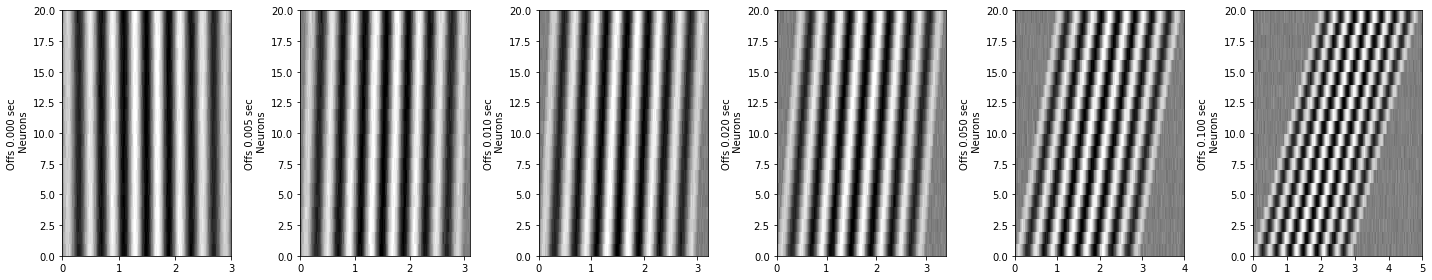

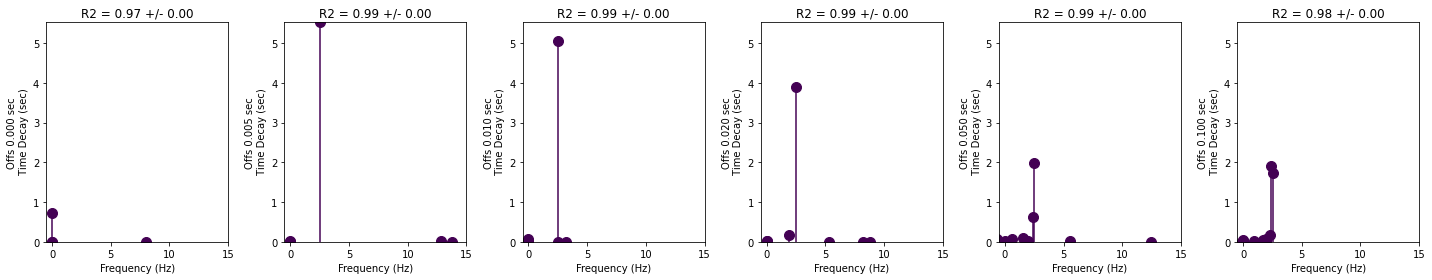

In [31]:
### We generate neural activity patterns that all 
### The function makes a noisy sequence, fits an A matrix, then makes a new noisy 
### how well the A matrix predicst the new sequence (i.e. cross validated R2)

### For each sequence we sweep the "fundamental frequency" and the offset between 
### individual neurons : 
fund_freq_test = np.array([ 2.5 ]) # Hz

# Sec, standard deviation of gaussian convolved with sine wave to yield 
# single neuron activation. Bigger means more of the sine wave is included in 
# the single neuron activation
gauss = 1.5

frac_offset = np.array([0., .005, .01, .02, .05, .1]) # Seconds
N_neurons = 20; # Total number of neurons per sequence; 
noise_level = 0.05; 

### Sweep through parameters; 
generate_spatiotemporal_patterns(fund_freq_test, frac_offset, N_neurons, 
                                 gauss_std = gauss, noise_level=noise_level,nreps=1, pad_zeros=0.,
                                 figsize = (20, 4))

You can see from the above example, that as long as there is a non-zero offset between each neuron (every column except first column), there $A$ matrix recovers the fundamental frequency (in this case 2.5 Hz). Try out other frequencies -- for example, try 10 Hz and see what happens at 10 Hz w/ 0.1 sec time decay.  

So rotational dynamics of a specific frequency can be generated by oscillations at the appropriate frequency as long as there is a phase offset between individual observations. In fact there can just be a single offset and the rest of the neurons can be synchronized: 

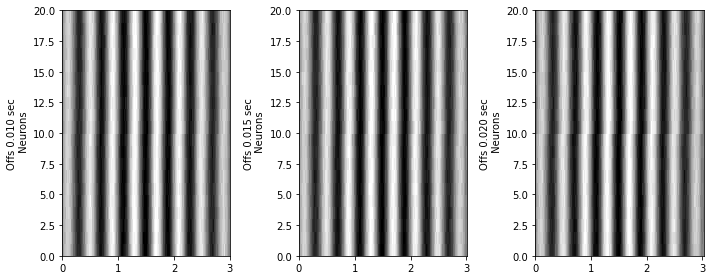

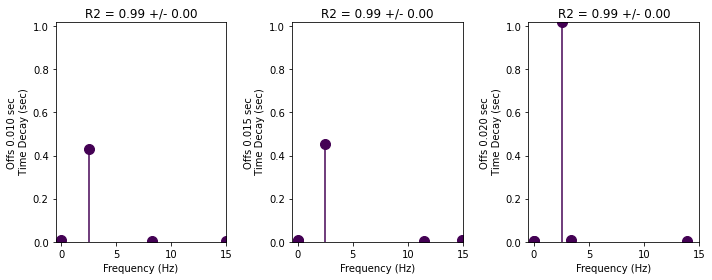

In [33]:
fund_freq_test = np.array([ 2.5 ]) # Hz
gauss = 1.5

# Method to have two populations that are phase offset from one another instead 
# of all neurons with a phase offset: 
frac_offset = ['sing_offs_.01', 'sing_offs_.015', 'sing_offs_.02'] 

N_neurons = 20; # Total number of neurons per sequence; 
noise_level = 0.05; 

### Sweep through parameters; 
generate_spatiotemporal_patterns(fund_freq_test, frac_offset, N_neurons, 
                                 gauss_std = gauss, noise_level=noise_level,nreps=1, 
                                 pad_zeros=0., figsize = (10, 4))



This is certainly the most obvious structure giving rise to rotational dynamics, however it is unusual to observe such obviously oscillating neural activity in motor regions of the brain. A structure that is more commonly found are neurons that have monophasic or multiphasic patterns that are activated at preferred times during the behiavior -- what we loosely term "sequential activity". Below we explore how sequential activity may exhibit rotational dynamics as well.

# Case 2: Sequential Activity

Below we'll generate a sequence. The sequence is composed of 10 "neurons" that each exhibit the same single activation, but at a slight time offset to one another. The activation is composed of a sine wave (frequency dictated by ```fund_freq```) multiplied by a gaussian (standard deviation dictated by ```gauss_std```). ```frac_offset``` determines what the offset between individual neurons in the sequence are (fraction of cycle of ```fund_freq```). ```total_length``` dictates the length of the sequence, and ```dt``` is the timestep size (10 ms). 



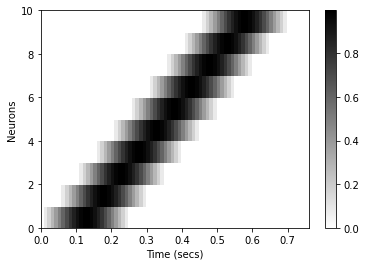

In [35]:
fund_freq = 2; # Hz, frequency of individual neuron response
gauss_std = .125 #sec, std of Gaussian convolved with sine wave to give individual neuron response
frac_offset = .1 # in cycles, offset between each neuron 
total_length = 0.5 # seconds
dt = 0.01 # seconds 

### Generate sequence data ##
seq_data = seq_utils.generate_seq(fund_freq, gauss_std, frac_offset, total_length=total_length, dt = dt)

### Plot data ###
nT, nD = seq_data.shape
data_t = np.arange(nT+1) * dt 
f, ax = plt.subplots()
cax = ax.pcolormesh(data_t, np.arange(nD+1), seq_data.T, cmap='binary')
ax.set_ylabel('Neurons')
ax.set_xlabel('Time (secs)')
cbar = f.colorbar(cax)

Before trying to analyze the dynamics of this spatiotemporal pattern, lets first try to visualize a small part of the high dimensional neural space first in 2D then 3D: 

Text(0, 0.5, 'Neuron 1')

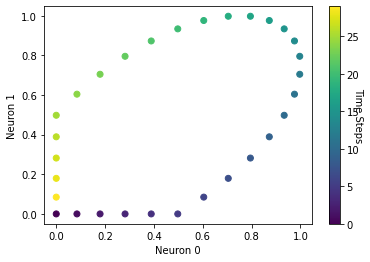

In [36]:
### Lets try first to look at this in a 2D space, looking at the first 2 neurons: 
f, ax = plt.subplots()

## Number of seconds to plot: 
nsec = 0.3;
npts = int(nsec / dt) ## Converted to indices

### Color is time steps
cax = ax.scatter(seq_data[:npts, 0], seq_data[:npts, 1], s=None, c=np.arange(npts))
cbar = f.colorbar(cax)
cbar.set_label('Time Steps', rotation=270)
ax.set_xlabel('Neuron 0')
ax.set_ylabel('Neuron 1')

Here we can see that the activity of the first two neurons may present as oscillation. What frequency would this oscillation show up as? Consider that it takes ~0.3 seconds for the full cycle to complete, which would show up as an oscillation with a frequency of ~3.3 Hz

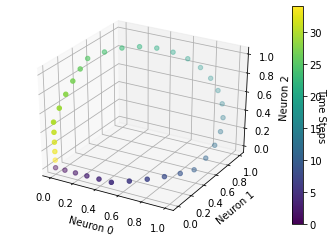

In [39]:
### Lets try the same thing, but now in 3D with the top 3 neurons: 
### Setup a 3D plot: 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

nsec = 0.35; 
npts = int(nsec / dt)
cax = ax.scatter3D(seq_data[:npts, 0], seq_data[:npts, 1], zs=seq_data[:npts, 2], c=np.arange(npts))
ax.set_xlabel('Neuron 0')
ax.set_ylabel('Neuron 1')
ax.set_zlabel('Neuron 2')

cbar = fig.colorbar(cax)
cbar.set_label('Time Steps', rotation=270)

Here, this oscillation now looks to be a bit longer, taking ~0.35 sec to fully complete, suggesting that the oscillation frequency would be close to 2.8 Hz; So what happens if we fit an A matrix on the full dataset? How does it approximate the different oscillations present in the data? 

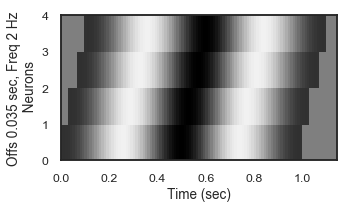

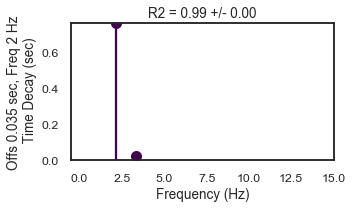

In [83]:
### Here we'll use the same parameters as above, but use our dynamics function: 

fund_freq_test = np.array([ 2. ]) # Hz
gauss = .5
# Method to have two populations that are phase offset from one another instead 
# of all neurons with a phase offset: 
dt_offset = [.035] ### Not that frac offset of 0.1 from above is a 0.05 sec offset

total_length = None; #0.5; # Total number of neurons per sequence; 
noise_level = 0.0; 
dt =.01
### Sweep through parameters; 
Aest, data = generate_spatiotemporal_patterns(fund_freq_test, dt_offset, 4,
                                total_length=total_length, gauss_std = gauss, 
                                noise_level=noise_level,nreps=1, pad_zeros=0.,
                                return_data = True, figsize=(5, 3))

Notice in the above plot that there is a mix of frequencies represented. Plot the different flow fields that capture the dynamics below and notice which frequencies appear:  

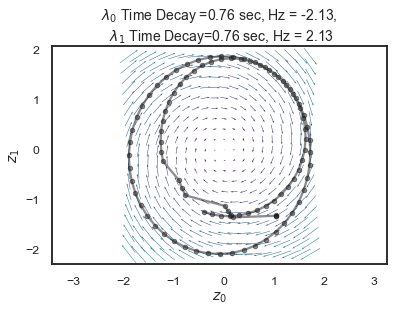

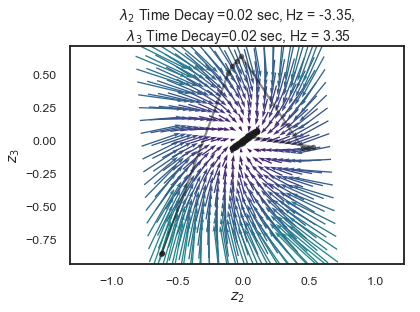

In [84]:
### Note that the first 100 time steps (1 second) are plotted in black
### Can adjust flow fields for easier visualization --> 
  ## scale = length of arrow. Lower values length the arrow tail
  ## width = width of the arrow. Lower values make the arrows thinner

_, nD = data.shape
color_max_lim = 0.8
arrow_scale = 0.8
arrow_width = 0.04; 

for i in range(np.min([5, int(nD/2)])):
  lds_utils.flow_field_plot_top_dim(Aest, data, dt, 
                                      dim0=int(i*2), dim1=int((i*2)+1),
                                      scale = arrow_scale, width = arrow_width/4., cmax = color_max_lim)

Overall, the A matrix creates quite a mix of oscillatory modes in order to represent the above sequence. One thing to keep in mind is that the flow field representation can be **misleading**. Consider above the $\lambda_8$ vs $\lambda_9$ plot. The arrows are very large, but if we look at the time decay of the eigenvalues we can see that the are on the same order as a single timestep (0.01 sec), meaning that they're representing modes that don't persist very long. On the other hand, the arrows in the $\lambda_0$ vs. $\lambda_1$ plot are smaller, meaning that this mode predicts that the neural state stays in the same place. These predictions are "strong" in the sense that they make a non-zero prediction for what the state should be at the next time point. Thus, the "strength" of dynamics should not be inferred from size of the arrows in the flow field plots. These plots just illustrate the behavior of the dynamics.   

So in this case, we can see that we can get low frequency rotational dynamics, despite individual neural responses not showing strong, persistant oscillatory components. Let's compare the frequencies in the individual neural components to the dominant frequencies uncovered in the dynamics matrix: 

R2 of Aest 1.00


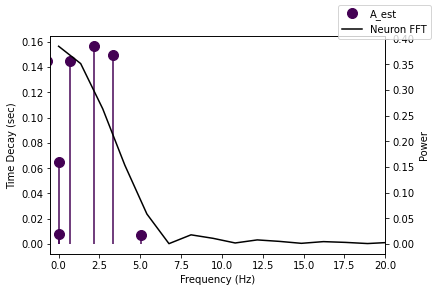

In [45]:
##### Estimate the FFT of each neuron and estimate the frequencies of the dynamics: 
f, ax = plt.subplots()
lds_utils.eigenspec(Aest, axi=ax, xlim=(-.5, 20.), labels = ['A_est'])

ax2 = ax.twinx()
xf, px = seq_utils.simple_fft(data[:, 0], 1/dt)
ax2.plot(xf, px, 'k-', label='Neuron FFT')
ax2.set_ylabel('Power')

### Add eigspec to this plot 
f.legend()

### Print R2 ###
print('R2 of Aest %.2f' %lds_utils.get_population_R2(data[1:,:], np.dot(Aest, data[:-1, :].T).T))

Here we can see that the individual neuron responses contain substantial low frequency content. Let's try seeing how this changes as we change the underlying fundamental frequency: 

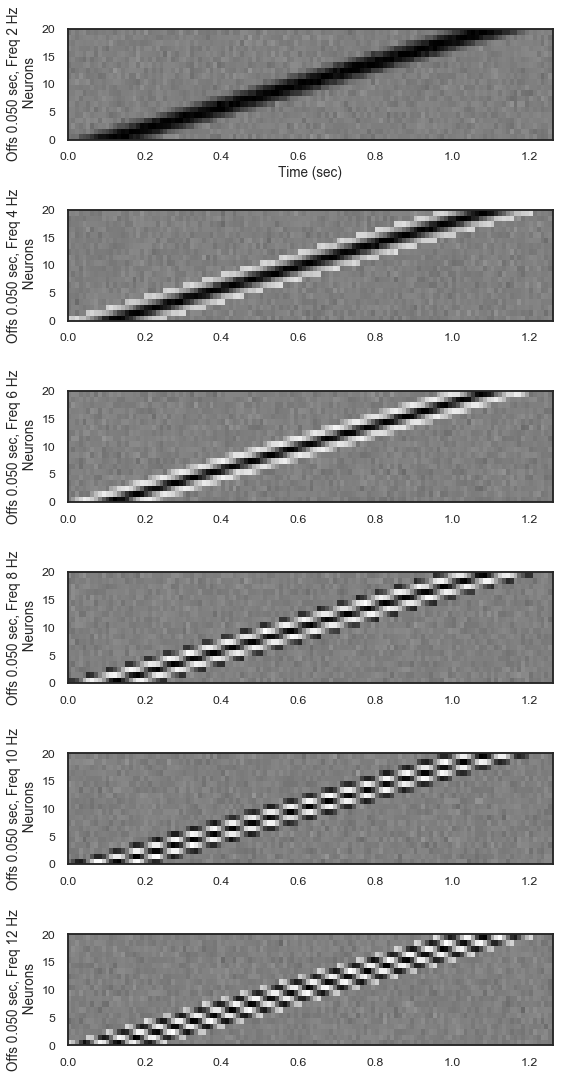

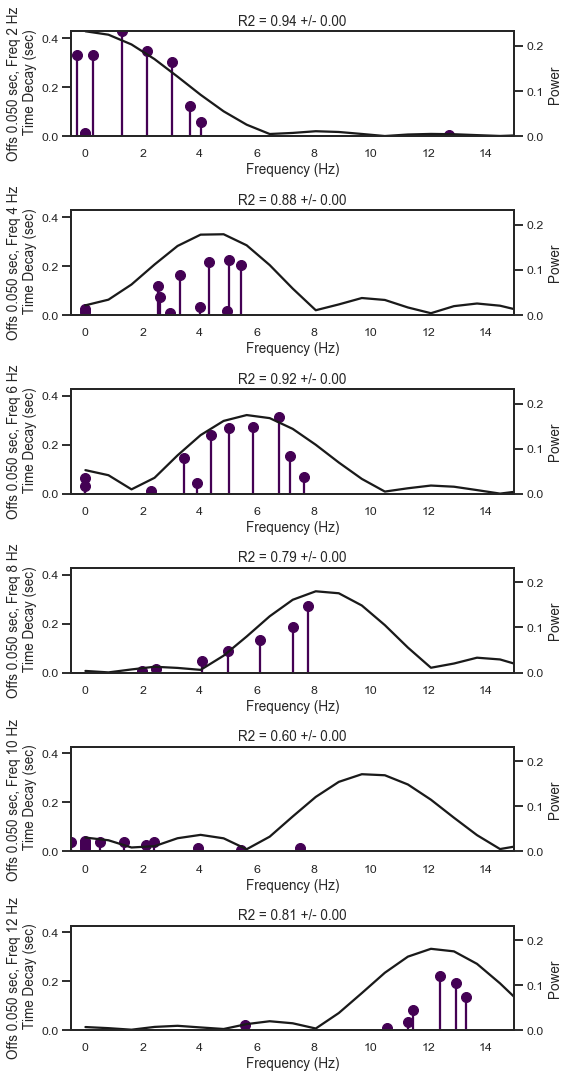

In [52]:
fund_freq_test = np.array([ 2, 4, 6, 8, 10, 12]) # Hz
gauss = .125
# Method to have two populations that are phase offset from one another instead 
# of all neurons with a phase offset: 
frac_offset = [.05] 
total_length = None; # Total number of neurons per sequence; 
noise_level = 0.05; 

generate_spatiotemporal_patterns(fund_freq_test, frac_offset, 20,
                        total_length=total_length, gauss_std = gauss, 
                        noise_level=noise_level,nreps=1, pad_zeros=0.,
                        return_data = False, figsize=(8, 15), add_fft = True)


We can see that overall the main frequencies that the dynamics matrix discovers are within the frequencies represented by the individual neurons, with fewer persistent low frequency oscillations as the underlying frequency content of the individual neurons increases. 

Finally, we ask how do the frequencies represented change as a function of phase offset between the neurons? Note that the phase offset between neurons also influence to total sequence time, since the number of neurons are kept constant. 

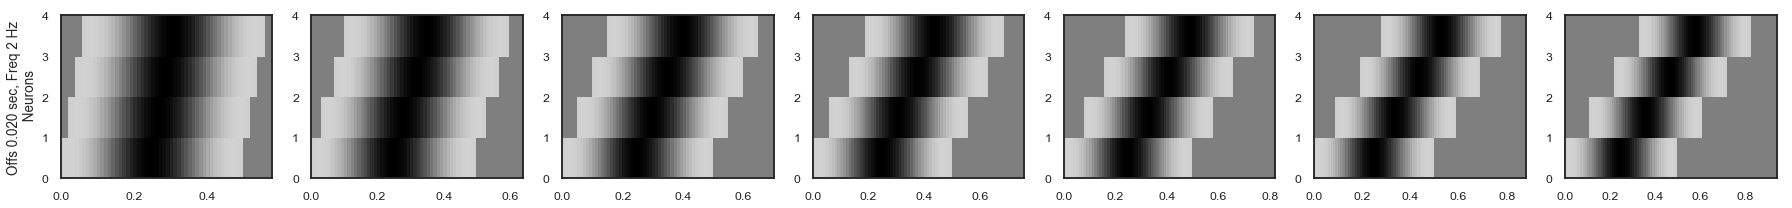

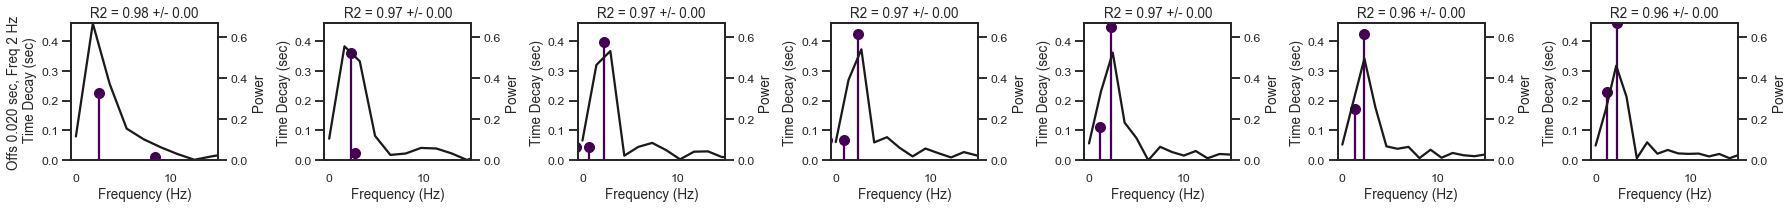

In [6]:
### Lets also try this now where we have the total number of neurons set, but vary the offsets; ###
fund_freq_test = np.array([2. ]) # Hz
gauss = 1./fund_freq_test[0]*.5

#dt_offset = [.005, .02, .04, .08, .12, .16, .2, .3 ] 
#dt_offset = [.02, .04, .08, .16, .2, .3 ] 
dt_offset = np.arange(.02, .125, .015)
total_length = None; # Total number of neurons per sequence; 
noise_level = 0.0; 
N_neurons = 4

### Sweep through parameters; 
generate_spatiotemporal_patterns(fund_freq_test, dt_offset, N_neurons,
                                total_length=total_length, gauss_std = gauss, 
                                noise_level=noise_level,nreps=1, pad_zeros=0.,
                                 figsize = (25, 3), add_fft = True)

In [43]:
1./2.6

0.3846153846153846

Here, we can see differences in the low frequencies that are used to fit each sequence within the 1-5 Hz range. The longer the sequence gets (due to greater phase offsets), the lower the frequencies get. To quantify this more readily, we can estimate an "average" non-zero frequency (weighted by time decay) for each A matrix, and plot the average non-zero frequency as a function of sequence length: 


/Users/preeyakhanna/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in log


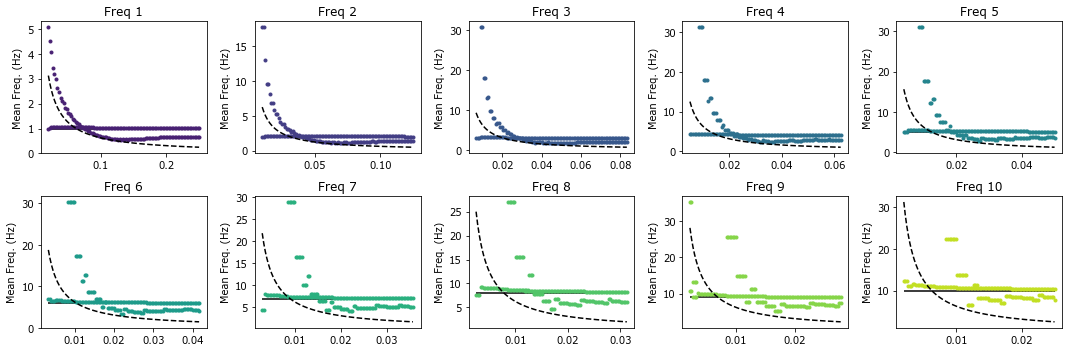

In [22]:
### Main parameters to sweep ###
N_neurons = 4
noise_level = 0.0
dt = .005; 
frequencies = np.arange(1, 11, 1)
#frequencies = [2., 3.]
hf_freq = np.max([int(1), int(len(frequencies)/2.)])

## Generate plot / colors
f, ax = plt.subplots(figsize=(15, 5), ncols = int((len(frequencies))/2), nrows = 2)
#f, ax = plt.subplots(figsize=(15, 5), ncols = 1, nrows = 2)
#ax = ax[:, np.newaxis]

cols = plt.cm.viridis(np.linspace(0., 1, 12))

### Sweep through differnet underlying fundamental frequencies; 
for i_f, freq in enumerate(frequencies):
  gauss = 1./freq*1.
  ### Containers for mean frequency / sequence length ###
  mn_f = [];
  seq_l = []; 
  dt_ = []; 
  
  ### Set the time offsets as a function of frequency to make sure there's enough overlap
  half_cycle_time = (1/freq)*0.25
  hund_cycle_time = (1/freq)*.02
  dt_offset = np.linspace(hund_cycle_time, half_cycle_time, 100)
  #dt_offset = np.arange(.02, .125, .015)
    
  ### For each DT ###
  for i_off, dt_off in enumerate(dt_offset):
    ### Frac of cycle 
    frac = dt_off*freq

    ### Get sequence data
    data = seq_utils.generate_seq(freq, gauss, dt_off, N_neurons=N_neurons, dt=dt)

    ### Get seq length: 
    mod = np.sum(np.abs(data), axis=1)
    mod_ix = np.nonzero(mod)[0]
    
    ### Step backward:
    i = len(mod_ix) - 1
    while mod[mod_ix[i]] == 0:
        i -= i
    seq_length = mod_ix[i]*dt
    
    ### Add some noise 
    data_pls_noise = data + noise_level*np.random.randn(data.shape[0], data.shape[1])

    ### Estimate the A matrix 
    Aest = np.linalg.lstsq(data_pls_noise[:-1, :], data_pls_noise[1:, :], rcond=None)[0] 
    Aest = Aest.T

#     arrow_scale = 0.8
#     arrow_width = .04
#     color_max_lim = .5
#     for i in range(2):
#       lds_utils.flow_field_plot_top_dim(Aest, data, dt, 
#                                       dim0=int(i*2), dim1=int((i*2)+1),
#                                       scale = arrow_scale, width = arrow_width, cmax = color_max_lim)
    
    
    ### Get the eigenvalue 
    ev, _ = np.linalg.eig(Aest)

    ### Get the freuqencies / time delays ###
    frequencies = np.angle(ev)/(2*np.pi*dt)
    time_decay = -1/np.log(np.abs(ev))*dt

    ### Get the positive frequencies ###
    ix_nonneg = np.nonzero(np.logical_and(frequencies > 0, frequencies < 50))[0]
    
    if len(ix_nonneg) == 0:
      mn_f.append(np.nan)
    else:
      ### weighted average based on time decay ###
      mn_f.append(np.dot(frequencies[ix_nonneg], time_decay[ix_nonneg]) / np.sum(time_decay[ix_nonneg]))

    ### seq length ###
    seq_l.append(seq_length)
    dt_.append(dt_off)
    
    ### Plot curve 
    rwz = int(i_f/hf_freq)
    clz = int(i_f%hf_freq)

    ax[rwz, clz].plot([dt_off]*len(ix_nonneg), frequencies[ix_nonneg], '.', color=cols[int(freq)])
  #ax[rwz, clz].plot(seq_l, mn_f, '.-', label='Freq %.1f Hz' %(freq), color = cols[int(freq)])

  xmin = np.min(dt_)
  xmax = np.max(dt_)

  #ax[rwz, clz].set_xlabel('DT Onset; ')
  ax[rwz, clz].set_ylabel('Mean Freq. (Hz)')
  ax[rwz, clz].set_title('Freq %d' %(freq))
  #ax[rwz, clz].set_xlim([.1, 1.3])
  #ax[rwz, clz].set_ylim([freq-.2, freq + .2])
  sd = np.arange(xmin, xmax, .01)
  
  ## Sequence duration ###
  #ax[rwz, clz].plot(sd, 1./sd, 'k--')
  ax[rwz, clz].hlines(freq, xmin, xmax, 'k')
  ax[rwz, clz].plot(dt_, 0.25*(1./N_neurons)*1./np.hstack((dt_)), 'k--')
  #ax[rwz, clz].plot(seq_l, freq + 1./np.array(seq_l), 'k--')
#f.legend()
f.tight_layout()


In [22]:
sd = np.arange(.1, 1., 100)

Overall there is a trend towards lower mean oscillatory frequencies with increasing sequence lengths. Each underlying frequency still maintains its overall frequency concentration around the fundamental frequency, with the increasing sequence length exhibits a reduction in mean frequency driven by the need for the dynamics matrix to capture the lower frequency structure responsible for the full sequence. 

Quick summary of what we've found so far: 


*   Sinusoids can give low frequency rotational oscillations in a fairly trivial way, i.e if there is a non-zero offset between two low frequency sine waves (Case I) 
*   Sequential activations of activity can also give low frequency rotational oscillations due to the rotational structure in neural state space that emerges with sequential activations. 
*   If the underlying single neuron activation is composed of higher frequency activity, the frequencies represented in the dynamcis matrix will be higher. 
*   The longer the sequence is, the lower the weighted mean of the positive frequencies is. Thus, changes in the lengths of analyzed neural data (e.g. with learning or recovery) could explain shifts in the frequency distribution of the dynamics. 

The last point we'll consider is whether arbitrary waveforms (i.e. white noise) can be captured by a dynamics matrix if the waveform is "predictable" in the sense that it is exactly replicated from one neuron to the next with an offset.




# Case 3: White Noise

First we'll consider unfiltered noise, and give the dynamics matrix the best chance at capturing change from time point to time point by offsetting the same waveform by a few bins: 

Text(0, 0.5, 'Neurons')

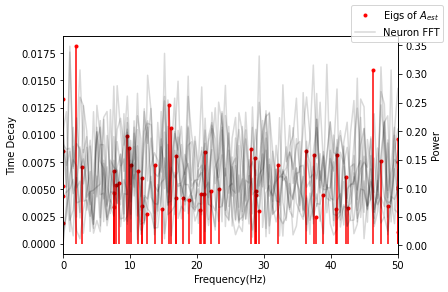

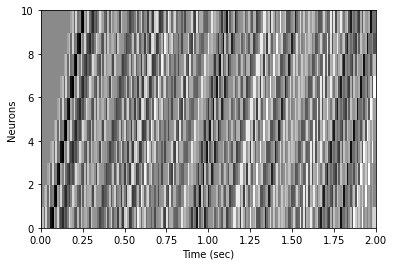

In [69]:
### Generate Noise Data ###  
f, ax = plt.subplots()
fdat, axdat = plt.subplots()

ax2 = ax.twinx()

### Time step
dt = .01

### Desired sequence time 
seq_time = 2.0 # seconds
seq_len = int(seq_time/dt) 

### dt offset: how much time to offset
dt_offs = .02; #seconds
ind_offs = int(dt_offs/dt)

### number of trials 
nreps = 10
N_neurons = 10 

### For many repetitions, generate data, estimate FFT of single waveform, estimate 
### dynamics matrix: 
for i in range(nreps):

  ### Single neuron activation is noise ##
  single_neur_activation = np.random.randn(seq_len)

  ### Data matrix: 
  data = np.zeros((N_neurons, seq_len))
  nD, nT = data.shape

  ### Fill in the data matrix with copy of x, shifted in time  
  for d in range(nD):

    if d == 0:
      data[d, :] = single_neur_activation.copy()
    else:
      data[d, (ind_offs*d):] = single_neur_activation[:-1*(ind_offs*d)].copy()
  
  ### Transpose data to nT x nD, as usual; 
  data = data.T

  ### Get FFT of waveform; 
  xf, px = seq_utils.simple_fft(data[:, 0], 1/dt)
  if i == 0:
    ax2.plot(xf, px, 'k-', label='Neuron FFT', alpha=0.15)
  else:
    ax2.plot(xf, px, 'k-', alpha=0.15)
  
  ### Estimate A
  Aest = np.linalg.lstsq(data[:-1, :], data[1:, :], rcond=None)[0] 
  Aest = Aest.T
  ev, _ = np.linalg.eig(Aest)

  ### Frequency and time decay of eigenvalues ###
  FR = np.angle(ev)/(2*np.pi*dt)
  TD = -1/np.log(np.abs(ev))*dt 
  if i == 0:
    ax.plot(FR, TD, 'r.', label = 'Eigs of $A_{est}$')
  
  else:
    ax.plot(FR, TD, 'r.')
  ax.vlines(FR, 0, TD, 'r')
  ax.set_xlim([0., 50.])
  
ax.set_ylabel('Time Decay')
ax.set_xlabel('Frequency(Hz)')
ax2.set_ylabel('Power')
f.legend()

axdat.pcolormesh(np.arange(seq_len+1)*dt, np.arange(N_neurons+1), data.T, cmap='binary')
axdat.set_xlabel('Time (sec)')
axdat.set_ylabel('Neurons')

First, the red lines illustrating the A matrix frequencies look scattered across the spectrum, but if we look close we can see that no line has a time decay longer than 10-20 ms. Thus, none of these eigenvalues are able to make predictions other than predicting "zero" at the next time step. This makes sense since in this example, we time offset between each neuron was > 1 bin, and since there's no predictable structure in the noise from time bin to time bin, the $A$ matrix has little chance at being able to make meaningful predictions. Try changing ```dt_offs``` to 0.01 (so one time step) and see of the time decays change. 



 What if we apply a commonly applied step in neuroscience when analyzing binned spike counts and smooth the data? Here we try this on a case of pure noise, not noise for a single neuron activation that is time shifted: 

R2 Train 0.90, R2 Test 0.86


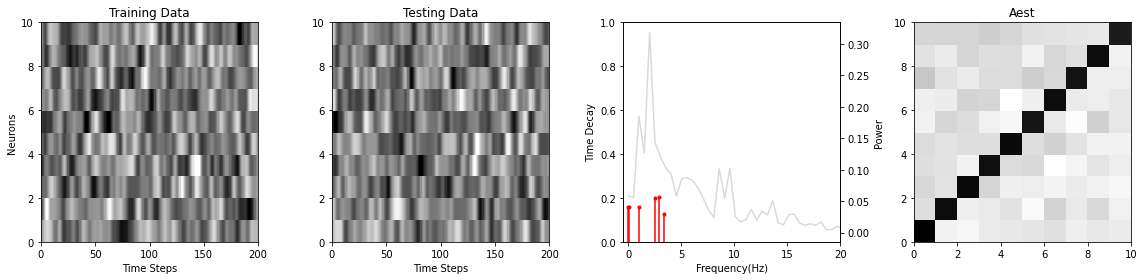

In [70]:
### Generate Low Pass Filtered Noise Data ###  
f, ax = plt.subplots(ncols = 4, figsize = (16, 4))
ax2 = ax[2].twinx()
n_neurons = 10

### We also use just random noise for this simulation, not even time offset: 
data = np.random.randn(seq_len, n_neurons)

### Low pass filter the noise: 
smooth_data = seq_utils.get_smoothed_spks(data[:, :, np.newaxis], dt, .02)
data = smooth_data[:, :, 0]

### Get FFT 
xf, px = seq_utils.simple_fft(data[:, 0], 1/dt)
ax2.plot(xf, px, 'k-', label='Neuron FFT', alpha=0.15)

### Estimate A
Aest = np.linalg.lstsq(data[:-1, :], data[1:, :], rcond=None)[0] 
Aest = Aest.T
ev, _ = np.linalg.eig(Aest)

### Get NEW data: 
data2 = np.random.randn(seq_len, n_neurons)

### Low pass filter the NEW data: 
smooth_data2 = seq_utils.get_smoothed_spks(data2[:, :, np.newaxis], dt, .02)
data2 = smooth_data2[:, :, 0]

r2_train = lds_utils.get_population_R2(data[1:, :], np.dot(Aest, data[:-1, :].T).T)
r2_test = lds_utils.get_population_R2(data2[1:, :], np.dot(Aest, data2[:-1, :].T).T)
print('R2 Train %.2f, R2 Test %.2f' %(r2_train, r2_test))

### Freq
FR = np.angle(ev)/(2*np.pi*dt)
TD = -1/np.log(np.abs(ev))*dt 
ax[2].plot(FR, TD, 'r.')
ax[2].vlines(FR, 0, TD, 'r')
ax[2].set_xlim([-.5, 20.])

ax[2].set_ylabel('Time Decay')
ax[2].set_xlabel('Frequency(Hz)')
ax2.set_ylabel('Power')
ax[2].set_ylim([0., 1.])

### Plot the data ### 
ax[0].pcolormesh(data.T, cmap='binary', vmin = -1, vmax = 1)
ax[0].set_ylabel('Neurons')
ax[0].set_xlabel('Time Steps')
ax[0].set_title('Training Data')
ax[1].set_xlabel('Time Steps')
ax[1].set_title('Testing Data')
ax[1].pcolormesh(data2.T, cmap='binary', vmin = -1, vmax = 1)

### Plot the A matrix ###
ax[3].pcolormesh(Aest, cmap='binary')
ax[3].set_title('Aest')
f.tight_layout()

### Plot some examples of LF dynamics flow fields: 



We can clearly see that if data is smoothed sufficiently, it can look predictable from one timestep to the next, and can exhibit rotational dynamics (above, right). Note that the time decay of these dynamics is relatively short (all < 0.3 seconds), but not so short that its obviously noise. Since $A$ is only estimating single time steps, the more smoothing that happens, the more the $A$ matrix will resemble the identity matrix (above, right). Thus, in order to ensure that the amount of dynamics observed in data is indeed greater than chance level, it is good practice to shuffle data and apply the same smoothing functions used for analysis and assess the $R^2$ obtained and the frequency distribution of the eigenvalues. 

# Conclusion

The objective of this exercise was to highlight the simple, vanilla discrete linear dynamical system as an analysis tool. Although a simple linear regression, the tool enables identification of spatial modes (eigenvectors) exhibiting consistent temporal structure (eigenvalues), and may be expecially useful in cases where data is expected to be lower dimensional and exhibit predictable temporal structure. 

Given the recent emphasis on rotational dynamics in motor cortical datasets during stereotyped behaviors reported in literature, we dedicate the final section to "reverse engineering" what types of spatiotemporal patterns could produce similar features. We uncover that low frequency modes can be generated by oscillations with a phase offset (case 1), sequences that exhibit neural activations that are low frequency and are of a specific length (case 2), or by filtered noise. Both case 1 and case 3 seem unlikely strategies for the brain to employ during movement execution, and so we hypothesize that the structure underlying low frequency dynamics is likely sequential activations of neurons with a specific sequence duration (related to behavioral analysis window, or length of behavior).
